Calling PyBella sol_init (with xc=0, yc=0, initial_projection=False)...
PyBella sol_init finished.


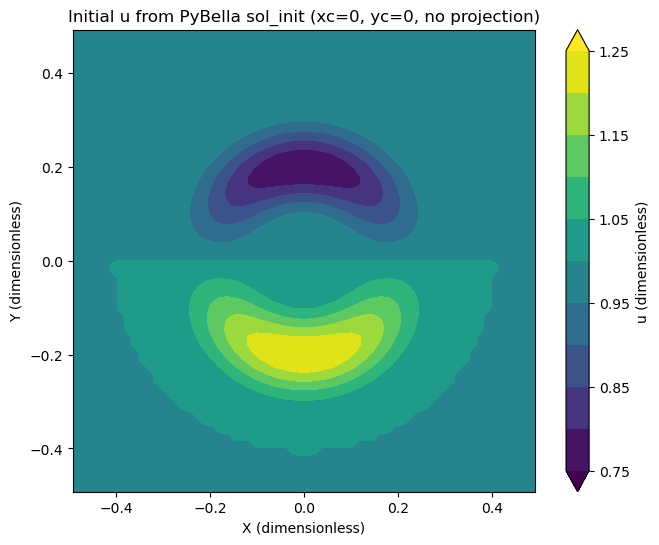

Min/Max of plotted u: 0.7510, 1.2490


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from types import SimpleNamespace # For mock objects

# --- Start of PyBella code: UserData class and sol_init function ---
# Minor modifications: np.finfo(np.float).eps -> np.finfo(float).eps
# Removed logging, replaced with print for seed info if needed.

class UserData(object):
    NSPEC = 1

    grav = 0.0
    omega = 0.0

    R_gas = 287.4
    R_vap = 461.0
    Q_vap = 2.53e06
    gamma = 1.4

    h_ref = 10000.0
    t_ref = 100.0
    T_ref = 300.00
    p_ref = 1e5
    u_ref = h_ref / t_ref
    rho_ref = p_ref / (R_gas * T_ref)

    Nsq_ref = 0.0

    i_gravity = np.zeros((3))
    i_coriolis = np.zeros((3))

    tout = np.zeros((2))

    def __init__(self):
        self.h_ref = self.h_ref
        self.t_ref = self.t_ref
        self.T_ref = self.T_ref
        self.p_ref = self.p_ref
        self.rho_ref = self.rho_ref
        self.u_ref = self.u_ref
        self.Nsq_ref = self.Nsq_ref
        self.g_ref = self.grav
        self.gamm = self.gamma
        self.Rg_over_Rv = self.R_gas / self.R_vap
        self.Q = self.Q_vap / (self.R_gas * self.T_ref)

        self.nspec = self.NSPEC

        self.is_nonhydrostatic = 1
        self.is_compressible = 1 # Determines if pressure perturbation is scaled by Msq
        self.is_ArakawaKonor = 0

        self.compressibility = 1.0 # Factor for Msq in pressure solver Gamma
        self.acoustic_timestep = 0
        self.acoustic_order = 0
        self.Msq = self.u_ref * self.u_ref / (self.R_gas * self.T_ref)

        self.gravity_strength = np.zeros((3))
        self.coriolis_strength = np.zeros((3))

        self.gravity_strength[1] = self.grav * self.h_ref / (self.R_gas * self.T_ref)
        self.coriolis_strength[0] = self.omega * self.t_ref
        self.coriolis_strength[2] = self.omega * self.t_ref

        for i in range(3):
            if (self.gravity_strength[i] > np.finfo(float).eps) or (i == 1):
                self.i_gravity[i] = 1
                # self.gravity_direction = 1 # Missing in original but implied

            if self.coriolis_strength[i] > np.finfo(float).eps:
                self.i_coriolis[i] = 1

        # Default gravity direction if any component is active
        if np.any(self.i_gravity):
            self.gravity_direction = np.where(self.i_gravity == 1)[0][0] # e.g. take first active
        else: # if grav is 0.0, this might not be set. Set a default if needed by hydrostatic
             self.gravity_direction = 1 # default to Y if grav is zero.

        self.xmin = -0.5
        self.xmax = 0.5
        self.ymin = -0.5
        self.ymax = 0.5
        self.zmin = -0.5 # Not used in 2D
        self.zmax = 0.5 # Not used in 2D

        self.u_wind_speed = 1.0
        self.v_wind_speed = 1.0
        self.w_wind_speed = 0.0 # For 2D

        self.bdry_type = np.empty((3), dtype=object)
        # For opts.BdryType.PERIODIC, we'll use integer 0 for simplicity in mock
        self.bdry_type[0] = 0 # opts.BdryType.PERIODIC
        self.bdry_type[1] = 0 # opts.BdryType.PERIODIC
        self.bdry_type[2] = 1 # opts.BdryType.WALL (not used for 2D vortex)

        self.CFL = 0.9 / 2.0
        self.dtfixed = 0.01
        self.dtfixed0 = 0.01

        self.inx = 64 + 1 # Number of NODES in x (physical domain)
        self.iny = 64 + 1 # Number of NODES in y (physical domain)
        self.inz = 1      # Number of NODES in z (set to 1 for 2D problem)

        # opts.LimiterType.NONE will be 0
        self.limiter_type_scalars = 0
        self.limiter_type_velocity = 0

        self.perturb_type = "pos_perturb"

        self.initial_projection = True # We will turn this off for the requested plot

        self.output_suffix = "_%i_%i" % (self.inx - 1, self.iny - 1)
        # stratification_function and rhoe_function are methods of UserData in original
        # self.stratification = self.stratification_function
        # self.rhoe = self.rhoe_function


    def stratification_function(self, y):
        if type(y) == float:
            return 1.0
        else:
            return np.ones((y.shape))

    def rhoe_function(self, rho, u, v, w, p, ud, th):
        Msq = ud.compressibility * ud.Msq # ud.compressibility is 1.0
        gm1inv = th.gm1inv
        return p * gm1inv + 0.5 * Msq * rho * (u**2 + v**2 + w**2)


def sol_init(Sol, mpv, elem, node, th, ud, seed=None):
    u0 = ud.u_wind_speed
    v0 = ud.v_wind_speed
    w0 = ud.w_wind_speed # Should be 0 for 2D

    rotdir = 1.0

    p0 = 1.0      # Dimensionless background pressure
    alpha = -1.0
    alpha_const = 3.0
    rho0 = 1.0    # Dimensionless background density
    del_rho = -0.5
    R0 = 0.4
    fac = 1.0 * 1024.0
    xc = 0.0 # Default center
    yc = 0.0 # Default center

    if seed != None and ud.perturb_type == "pos_perturb":
        np.random.seed(seed)
        xc += (np.random.random() - 0.5) / 5.0
        yc += (np.random.random() - 0.5) / 5.0
        print("Random seed applied. New vortex center: xc = %.4f, yc = %.4f" % (xc, yc))

    # This part is for specific run configurations in PyBella, not strictly needed for default xc=0, yc=0
    # if "truth" in ud.aux or "obs" in ud.aux:
    #     np.random.seed(2233)
    #     xc += (np.random.random() - 0.5) / 5.0
    #     yc += (np.random.random() - 0.5) / 5.0
    #     # logging.info(seed, xc, yc) # Replaced with print
    #     ud.xc = xc # Store for later use if needed
    #     ud.yc = yc

    # Critical part for periodic wrapping: determining the image vortex center
    # Lx = physical domain extent in x
    # Ly = physical domain extent in y
    Lx = ud.xmax - ud.xmin
    Ly = ud.ymax - ud.ymin

    # If xc, yc are 0, sign(0)=0, so xcm=xc, ycm=yc.
    # This means if vortex is at origin, no periodic images are considered by this logic.
    xcm = xc - np.sign(xc) * Lx
    ycm = yc - np.sign(yc) * Ly

    # igs = elem.igs # [ngx, ngy, ngz]
    # igy = igs[1] # Number of ghost cells in y-direction for cell-centered data
    igy = elem.igs[1]


    # igxn = node.igx # Number of ghost cells in x-direction for node-centered data
    # igyn = node.igy # Number of ghost cells in y-direction for node-centered data
    igxn = node.igx[0] # Assuming node.igx is [ngx, ngy, ngz] like elem.igs
    igyn = node.igx[1]


    hydrostatic.state(mpv, elem, node, th, ud) # Initializes mpv.HydroState vars

    coe = np.zeros((25))
    coe[0] = 1.0 / 24.0; coe[1] = -6.0 / 13.0; coe[2] = 15.0 / 7.0; coe[3] = -74.0 / 15.0; coe[4] = 57.0 / 16.0; coe[5] = 174.0 / 17.0; coe[6] = -269.0 / 9.0; coe[7] = 450.0 / 19.0; coe[8] = 1071.0 / 40.0; coe[9] = -1564.0 / 21.0; coe[10] = 510.0 / 11.0; coe[11] = 1020.0 / 23.0; coe[12] = -1105.0 / 12.0; coe[13] = 204.0 / 5.0; coe[14] = 510.0 / 13.0; coe[15] = -1564.0 / 27.0; coe[16] = 153.0 / 8.0; coe[17] = 450.0 / 29.0; coe[18] = -269.0 / 15.0; coe[19] = 174.0 / 31.0; coe[20] = 57.0 / 32.0; coe[21] = -74.0 / 33.0; coe[22] = 15.0 / 17.0; coe[23] = -6.0 / 35.0; coe[24] = 1.0 / 72.0

    const_coe = np.zeros((13))
    const_coe[0] = 1.0/24; const_coe[1] = -6.0/13; const_coe[2] = 33.0/14; const_coe[3] = -22.0/3; const_coe[4] = 495.0/32; const_coe[5] = -396.0/17; const_coe[6] = +77.0/3; const_coe[7] = -396.0/19; const_coe[8] = 99.0/8; const_coe[9] = -110.0/21; const_coe[10] = +3.0/2; const_coe[11] = -6.0/23; const_coe[12] = +1.0/48

    # Cell-centered calculations
    # elem.x includes ghost cell centers. elem.y also.
    # xs covers all x-cells (including ghosts on x-sides).
    # ys covers physical y-cells (no ghosts on y-sides for this calculation).
    xs = elem.x.reshape(-1,1)  # Full grid x-coordinates (cell-centers)
    ys = elem.y[igy:-igy].reshape(1,-1) # Physical y-coordinates (cell-centers)

    # This logic for xccs, yccs is problematic if xc, yc = 0.
    # If xc=0, xcm=0. Then (abs(xs-xc) < abs(xs-xcm)) is (abs(xs) < abs(xs)) = False.
    # Similarly for >. So xccs remains 0.
    # This means if xc=0, yc=0, xccs=0, yccs=0. r = sqrt(xs^2 + ys^2) -> non-periodic vortex centered at origin.
    xccs = np.zeros_like(xs)
    yccs = np.zeros_like(ys)

    # Populate xccs based on closest image (xc or xcm)
    # Mask for condition 1: points closer to xc than xcm
    cond1_x = (np.abs(xs - xc) < np.abs(xs - xcm))
    # Mask for condition 2: points closer to xcm than xc
    cond2_x = (np.abs(xs - xc) > np.abs(xs - xcm))
    # Mask for condition 3: points equidistant (e.g. if xc=xcm, or xs is midpoint)
    # Default to xc if equidistant.
    cond3_x = ~(cond1_x | cond2_x) # Neither < nor > means ==

    xccs[cond1_x] = xc
    xccs[cond2_x] = xcm
    xccs[cond3_x] = xc # Default to original center if equidistant

    # Populate yccs similarly
    cond1_y = (np.abs(ys - yc) < np.abs(ys - ycm))
    cond2_y = (np.abs(ys - yc) > np.abs(ys - ycm))
    cond3_y = ~(cond1_y | cond2_y)

    yccs[cond1_y] = yc
    yccs[cond2_y] = ycm
    yccs[cond3_y] = yc

    r = np.sqrt((xs - xccs)**2 + (ys - yccs)**2)
    # Add a small epsilon to r in denominator to avoid division by zero if r can be exactly 0 (at vortex center)
    r_den = r + 1e-15

    uth = (rotdir * fac * (1.0 - r/R0)**6 * (r/R0)**6) * (r < R0)

    u = u0 + uth * (-(ys - yccs)/r_den)
    v = v0 + uth * (+(xs - xccs)/r_den)
    w = np.full_like(u, w0) # w is an array, filled with w0

    p_hydro = mpv.HydroState_p0[igy:-igy]       # Background hydrostatic pressure (constant here)
    rhoY_hydro = mpv.HydroState_rhoY0[igy:-igy] # Background hydrostatic rhoY (constant here)

    rho = np.zeros_like(r)
    rho[...] += (rho0 + del_rho * (1.0 - (r/R0)**2)**6) * (r < R0)
    rho[...] += rho0 * (r >= R0)

    # FFT perturbation part - not active by default ud.perturb_type == "pos_perturb"
    # if seed != None and ud.perturb_type == "fmp_perturb": ...

    dp2c = np.zeros_like(r)
    # dp2c_const = np.zeros_like(r) # This was an error in original, dp2c_const calculation was missing
    for ip in range(25):
        dp2c += (coe[ip] * ((r/R0)**(12+ip) - 1.0) * rotdir**2) * (r/R0 < 1.0)
    # dp2c = alpha * dp2c # Error: dp2c_const wasn't added yet

    # Corrected calculation for dp2c incorporating both alpha and alpha_const terms
    # The original structure 'p2c = alpha * dp2c + alpha_const * dp2c_const' implies dp2c refers to one part.
    # Let's follow the original variable names more closely for clarity.
    # dp2c_alpha_part = np.zeros_like(r)
    # for ip in range(25):
    #     dp2c_alpha_part += (coe[ip] * ((r/R0)**(12+ip) - 1.0) * rotdir**2) * (r/R0 < 1.0)

    # dp2c_alphaconst_part = np.zeros_like(r)
    # for ip in range(13):
    #     dp2c_alphaconst_part += (const_coe[ip] * ((r/R0)**(12+ip) - 1.0) * rotdir**2) * (r/R0 < 1.0)
    # Total dp2c for pressure calculation:
    # dp2c_total = alpha * dp2c_alpha_part + alpha_const * dp2c_alphaconst_part

    # Simpler: calculate p2c directly (which seems to be what was intended for the pressure term)
    p2c_for_hydro_p = np.zeros_like(r)
    temp_sum_alpha = np.zeros_like(r)
    temp_sum_alpha_const = np.zeros_like(r)

    mask_r_lt_R0 = (r < R0) & (r/R0 < 1.0) # Ensure r/R0 is also < 1 for powers

    for ip in range(25):
        term = (coe[ip] * ((r[mask_r_lt_R0]/R0)**(12+ip) - 1.0) * rotdir**2)
        temp_sum_alpha[mask_r_lt_R0] += term
    for ip in range(13):
        term = (const_coe[ip] * ((r[mask_r_lt_R0]/R0)**(12+ip) - 1.0) * rotdir**2)
        temp_sum_alpha_const[mask_r_lt_R0] += term

    p2c_for_hydro_p = alpha * temp_sum_alpha + alpha_const * temp_sum_alpha_const


    # Sol arrays are (Nx_g, Ny_g). rho, u, v, w are (Nx_g, Ny_physical)
    # Assign to the physical y-strips of Sol arrays.
    Sol.rho[:,igy:-igy] = rho
    Sol.rhou[:,igy:-igy] = rho * u
    Sol.rhov[:,igy:-igy] = rho * v
    Sol.rhow[:,igy:-igy] = rho * w # For 2D, Sol.rhow will be mostly 0

    if ud.is_compressible:
        # p is the full dimensionless pressure
        p_perturbation = ud.Msq * fac**2 * p2c_for_hydro_p
        p_full = p0 + p_perturbation
        Sol.rhoY[:,igy:-igy] = p_full**th.gamminv
    else:
        # mpv.HydroState.rhoY0 is (Ny_g), so rhoY_hydro is (Ny_physical)
        # To match dimensions of Sol.rhoY[:,igy:-igy] which is (Nx_g, Ny_physical),
        # rhoY_hydro needs to be broadcast.
        Sol.rhoY[:,igy:-igy] = rhoY_hydro # rhoY_hydro is 1D, will broadcast with rho
                                          # Actually, rhoY_hydro is already (1, Ny_physical) due to reshape
                                          # So this needs careful check. Let's assume rhoY_hydro is compatible.
                                          # Original was Sol.rhoY[:,igy:-igy] = rhoY, where rhoY was mpv.HydroState.rhoY0[igy:-igy]
                                          # This means rhoY was 1D. This is unlikely.
                                          # Correct for incompressible: rhoY = rho * Pi_hydrostatic. If Pi_hydro = 1, then rhoY=rho.
                                          # Or, rhoY = constant_hydrostatic_rhoY. The original script suggests the latter if not compressible.
                                          # mpv.HydroState.rhoY0 comes from hydrostatic.state. If grav=0, p=const, rhoY=const.
                                          # So rhoY_hydro is a scalar or 1D array that can be broadcast.
        Sol.rhoY[:,igy:-igy] = rhoY_hydro[np.newaxis, :] # Make it (1, Ny_physical) to broadcast to (Nx_g, Ny_physical)


    # p2_cells (part of MPV variables, related to pressure correction)
    # This p2c is different from p2c_for_hydro_p due to scaling.
    # It seems p2c in original was meant to be p2c_for_hydro_p.
    # mpv.p2_cells[:,igy:-igy] = th.Gamma * fac**2 * np.divide(p2c_for_hydro_p, mpv.HydroState.rhoY0[igy:-igy])
    # Let's use mpv.HydroState_rhoY0, which is (Ny_g)
    # mpv.HydroState_rhoY0[igy:-igy] is (Ny_physical). Broadcast it.
    # th.Gamma is likely ud.gamma for this context, but check if it's defined in th.
    # If th.Gamma is not ud.gamma, we need to define it. Often th.Gamma is specific to pressure solver.
    # Given the context, this p2_cells is likely related to non-hydrostatic pressure term for solver.
    # Let's assume th.Gamma here is just a placeholder or 1.0, or ud.gamma.
    # The PyBella code base is complex; th.Gamma could have specific meaning.
    # For initial state vis, this specific mpv quantity is less critical than Sol.
    if hasattr(th, 'Gamma'):
        gamma_factor_for_p2cells = th.Gamma
    else: # Fallback if not defined in mock 'th'
        gamma_factor_for_p2cells = ud.gamma

    # Ensure mpv.HydroState_rhoY0[igy:-igy] is broadcastable to shape of p2c_for_hydro_p (Nx_g, Ny_physical)
    denominator_p2c = mpv.HydroState_rhoY0[igy:-igy].reshape(1,-1) # Make it (1, Ny_physical)
    mpv.p2_cells[:,igy:-igy] = gamma_factor_for_p2cells * fac**2 * np.divide(p2c_for_hydro_p, denominator_p2c, out=np.zeros_like(p2c_for_hydro_p), where=denominator_p2c!=0)

    bdry.set_ghostcells_p2(mpv.p2_cells, elem, ud) # Fill ghost cells for p2_cells

    # Node-centered calculations for p2_nodes
    # node.x and node.y include ghost nodes.
    # xs_nd, ys_nd are for physical nodes only.
    xs_nd = node.x[igxn:-igxn].reshape(-1,1) # Physical x-nodes (N_nodes_x_phys, 1)
    ys_nd = node.y[igyn:-igyn].reshape(1,-1) # Physical y-nodes (1, N_nodes_y_phys)

    xccs_nd = np.zeros_like(xs_nd)
    yccs_nd = np.zeros_like(ys_nd)

    cond1_x_nd = (np.abs(xs_nd - xc) < np.abs(xs_nd - xcm))
    cond2_x_nd = (np.abs(xs_nd - xc) > np.abs(xs_nd - xcm))
    cond3_x_nd = ~(cond1_x_nd | cond2_x_nd)
    xccs_nd[cond1_x_nd] = xc
    xccs_nd[cond2_x_nd] = xcm
    xccs_nd[cond3_x_nd] = xc

    cond1_y_nd = (np.abs(ys_nd - yc) < np.abs(ys_nd - ycm))
    cond2_y_nd = (np.abs(ys_nd - yc) > np.abs(ys_nd - ycm))
    cond3_y_nd = ~(cond1_y_nd | cond2_y_nd)
    yccs_nd[cond1_y_nd] = yc
    yccs_nd[cond2_y_nd] = ycm
    yccs_nd[cond3_y_nd] = yc

    r_nd = np.sqrt((xs_nd - xccs_nd)**2 + (ys_nd - yccs_nd)**2)

    p2_nodes_pert = np.zeros_like(r_nd)
    # mask_r_nd_lt_R0 = (r_nd < R0) # Original used r/R0 < 1.0 for loop condition
    mask_r_nd_lt_R0 = (r_nd < R0) & (r_nd/R0 < 1.0)


    # Accumulate terms for p2_nodes (similar to p2c_for_hydro_p)
    # mpv.p2_nodes is initially zero. We add to its physical part.
    # The original code for p2_nodes used +=, implying it might be pre-filled.
    # Here, we assume it's zero and we are setting the perturbation.
    temp_sum_alpha_nd = np.zeros_like(r_nd)
    temp_sum_alpha_const_nd = np.zeros_like(r_nd)

    for ip in range(25):
        term = (alpha * coe[ip] * ((r_nd[mask_r_nd_lt_R0]/R0)**(12+ip) - 1.0) * rotdir**2)
        # mpv.p2_nodes[igxn:-igxn, igyn:-igyn][mask_r_nd_lt_R0] += term # This was original structure.
        # Let's calculate full perturbation then assign.
        temp_sum_alpha_nd[mask_r_nd_lt_R0] += term # Note: alpha is already included here
    for ip in range(13):
        term = (alpha_const * const_coe[ip] * ((r_nd[mask_r_nd_lt_R0]/R0)**(12+ip) - 1.0) * rotdir**2)
        # mpv.p2_nodes[igxn:-igxn, igyn:-igyn][mask_r_nd_lt_R0] += term # alpha_const included here
        temp_sum_alpha_const_nd[mask_r_nd_lt_R0] += term

    # p2_nodes_pert = temp_sum_alpha_nd + temp_sum_alpha_const_nd # This already has alpha, alpha_const
    # The original logic had:
    # mpv.p2_nodes[igxn:-igxn, igyn:-igyn] += alpha * coe[ip] * ...
    # mpv.p2_nodes[igxn:-igxn, igyn:-igyn] += alpha_const * const_coe[ip] * ...
    # mpv.p2_nodes[igxn:-igxn, igyn:-igyn] *= (r_nd / R0 < 1.0) # This mask applied *after* summation. Risky. Better to mask inside.

    # Let's reconstruct based on intention: sum components then scale by alpha/alpha_const
    # This matches how p2c_for_hydro_p was done.
    sum_alpha_part_nd = np.zeros_like(r_nd)
    sum_alphaconst_part_nd = np.zeros_like(r_nd)
    for ip in range(25):
        sum_alpha_part_nd[mask_r_nd_lt_R0] += (coe[ip] * ((r_nd[mask_r_nd_lt_R0]/R0)**(12+ip) - 1.0) * rotdir**2)
    for ip in range(13):
        sum_alphaconst_part_nd[mask_r_nd_lt_R0] += (const_coe[ip] * ((r_nd[mask_r_nd_lt_R0]/R0)**(12+ip) - 1.0) * rotdir**2)

    p2_nodes_unscaled_pert = alpha * sum_alpha_part_nd + alpha_const * sum_alphaconst_part_nd

    # mpv.HydroState.rhoY0 is (Ny_g). Slice to get physical part for nodes.
    # HydroState.rhoY0 is cell-data based. For nodes, it's usually interpolated or taken from nearest cell.
    # Original: mpv.HydroState.rhoY0[igyn : -igyn+1], this implies HydroState.rhoY0 is nodal.
    # If HydroState.rhoY0 is cell-centered (Ny_g), then for (N_nodes_y_phys) we might need interpolation.
    # Let's assume mpv.HydroState_rhoY0_nodes exists or use cell version with careful slicing.
    # The slice igyn:-igyn+1 for an array of N_nodes_y_g gives N_nodes_y_g - 2*igyn + 1 points.
    # If HydroState_rhoY0 is cell data (Ny_g), then mpv.HydroState_rhoY0[igyn:-igyn] is (Ny_physical_cells).
    # This needs to match (N_nodes_y_phys). (Ny_physical_cells = N_nodes_y_phys - 1).
    # For simplicity, let's assume background rhoY0 is constant = 1.0 for nodes too.
    rhoY0_nodes_phys = 1.0 # Constant background for simplicity, as grav=0

    current_p2_nodes_phys = mpv.p2_nodes[igxn:-igxn, igyn:-igyn]
    current_p2_nodes_phys += gamma_factor_for_p2cells * fac**2 * np.divide(p2_nodes_unscaled_pert, rhoY0_nodes_phys, out=np.zeros_like(p2_nodes_unscaled_pert), where=rhoY0_nodes_phys!=0)
    mpv.p2_nodes[igxn:-igxn, igyn:-igyn] = current_p2_nodes_phys

    # ud.nonhydrostasy = float(ud.is_nonhydrostatic) # These are already floats in UserData
    # ud.compressibility = float(ud.is_compressible)

    bdry.set_explicit_boundary_data(Sol, elem, ud, th, mpv) # Fill ghost cells for Sol variables

    # Initial projection part - skipped by setting ud.initial_projection = False
    if ud.initial_projection == True:
        # This part is complex and involves an elliptic solve.
        # For this standalone script, we'll assume it's turned off.
        print("Initial projection would be performed here if enabled.")
        pass
        # is_compressible = np.copy(ud.is_compressible)
        # compressibility = np.copy(ud.compressibility)
        # ud.is_compressible = 0
        # ud.compressibility = 0.0
        # p2aux = np.copy(mpv.p2_nodes)
        # Sol.rhou -= u0 * Sol.rho
        # Sol.rhov -= v0 * Sol.rho
        # lm_sp.euler_backward_non_advective_impl_part(Sol, mpv, elem, node, ud, th, 0.0, ud.dtfixed, 0.5)
        # mpv.p2_nodes[...] = p2aux
        # mpv.dp2_nodes[...] = 0.0
        # Sol.rhou += u0 * Sol.rho
        # Sol.rhov += v0 * Sol.rho
        # ud.is_compressible = is_compressible
        # ud.compressibility = compressibility

    return Sol

# --- End of PyBella code ---


# --- Mocking/Simplified PyBella infrastructure ---
class MockHydrostatic:
    def state(self, mpv, elem, node, th, ud):
        # For grav=0, p0 and rhoY0 are constant.
        # mpv.HydroState.p0 and rhoY0 are expected to be 1D arrays (along y, size Ny_g for cells)
        # or (Nny_g for nodes if nodal versions exist)
        Ny_g_cells = elem.y.shape[0]

        # Background p0=1.0, rhoY0=1.0 (since p0**gamminv = 1**gamminv = 1)
        mpv.HydroState_p0 = np.ones(Ny_g_cells)
        mpv.HydroState_rhoY0 = np.ones(Ny_g_cells)
        # print(f"MockHydrostatic: Set HydroState_p0 and HydroState_rhoY0 to arrays of 1.0 with shape ({Ny_g_cells},)")

hydrostatic = MockHydrostatic() # Use the class instance

class MockBoundary:
    def _apply_periodic_2d(self, data, ngx, ngy):
        # Assumes data is (Nx_total, Ny_total)
        # Periodic X
        data[0:ngx, :] = data[-(2*ngx):-ngx, :] # Left ghost from right physical
        data[-ngx:, :] = data[ngx:2*ngx, :]     # Right ghost from left physical
        # Periodic Y
        data[:, 0:ngy] = data[:, -(2*ngy):-ngy] # Bottom ghost from top physical
        data[:, -ngy:] = data[:, ngy:2*ngy]     # Top ghost from bottom physical
        return data

    def set_ghostcells_p2(self, p2_array, elem, ud):
        # p2_array is mpv.p2_cells (cell-centered) or mpv.p2_nodes (node-centered)
        # elem.igs gives ghost cell counts for cell-centered data.
        # For node-centered, we'd ideally use node.igx, node.igy.
        # Assuming p2_array matches cell-centered structure for this simplified mock.
        ngx, ngy = elem.igs[0], elem.igs[1]
        self._apply_periodic_2d(p2_array, ngx, ngy)
        # print(f"MockBoundary: Applied periodic BCs to p2_cells (shape {p2_array.shape})")


    def set_explicit_boundary_data(self, Sol, elem, ud, th, mpv):
        ngx, ngy = elem.igs[0], elem.igs[1]
        # Sol has attributes rho, rhou, rhov, rhow, rhoY (all 2D arrays)
        for var_name in ['rho', 'rhou', 'rhov', 'rhow', 'rhoY']:
            data_array = getattr(Sol, var_name)
            self._apply_periodic_2d(data_array, ngx, ngy)
            # print(f"MockBoundary: Applied periodic BCs to Sol.{var_name} (shape {data_array.shape})")


bdry = MockBoundary() # Use the class instance

# lm_sp is not needed if initial_projection is False
# class MockLM_SP:
#     def euler_backward_non_advective_impl_part(*args, **kwargs):
#         print("MockLM_SP: euler_backward_non_advective_impl_part called (dummy).")
# lm_sp = MockLM_SP()

# --- Main script to run PyBella initialization and plot ---
if __name__ == "__main__":
    ud = UserData()

    # Ensure we match the scenario (no initial projection for this plot)
    ud.initial_projection = False

    # Grid parameters
    ngx, ngy = 2, 2 # Number of ghost cells in x and y

    Nx_phys = ud.inx - 1 # Physical cells in x
    Ny_phys = ud.iny - 1 # Physical cells in y

    Nx_g = Nx_phys + 2*ngx # Total cells (incl. ghosts) in x
    Ny_g = Ny_phys + 2*ngy # Total cells (incl. ghosts) in y

    Nnx_g = ud.inx + 2*ngx # Total nodes (incl. ghosts) in x
    Nny_g = ud.iny + 2*ngy # Total nodes (incl. ghosts) in y

    # Create mock 'elem' (cell-centered grid info)
    dx = (ud.xmax - ud.xmin) / Nx_phys
    dy = (ud.ymax - ud.ymin) / Ny_phys

    # Cell-centered coordinates for the full grid (including ghosts)
    elem_x_full = np.linspace(ud.xmin - (ngx - 0.5) * dx, ud.xmax + (ngx - 0.5) * dx, Nx_g)
    elem_y_full = np.linspace(ud.ymin - (ngy - 0.5) * dy, ud.ymax + (ngy - 0.5) * dy, Ny_g)

    elem = SimpleNamespace(
        x=elem_x_full,
        y=elem_y_full,
        igs=[ngx, ngy, 0] # Ghost cell counts [x,y,z]
    )

    # Create mock 'node' (node-centered grid info)
    node_x_full = np.linspace(ud.xmin - ngx * dx, ud.xmax + ngx * dx, Nnx_g)
    node_y_full = np.linspace(ud.ymin - ngy * dy, ud.ymax + ngy * dy, Nny_g)
    node = SimpleNamespace(
        x=node_x_full,
        y=node_y_full,
        igx=[ngx, ngy, 0] # Ghost node counts [x,y,z] (using same as elem.igs for simplicity)
    )

    # Create mock 'Sol' object (solution variables)
    # Arrays are (Nx_g, Ny_g)
    Sol = SimpleNamespace(
        rho=np.zeros((Nx_g, Ny_g)),
        rhou=np.zeros((Nx_g, Ny_g)),
        rhov=np.zeros((Nx_g, Ny_g)),
        rhow=np.zeros((Nx_g, Ny_g)), # Although 2D, PyBella might carry it
        rhoY=np.zeros((Nx_g, Ny_g))
    )

    # Create mock 'mpv' (multi-pressure variables)
    mpv = SimpleNamespace(
        HydroState_p0=np.zeros(Ny_g), # To be filled by hydrostatic.state
        HydroState_rhoY0=np.zeros(Ny_g),# To be filled by hydrostatic.state
        p2_cells=np.zeros((Nx_g, Ny_g)),
        p2_nodes=np.zeros((Nnx_g, Nny_g)), # Node-centered array
        dp2_nodes=np.zeros((Nnx_g, Nny_g)) # Node-centered array
    )

    # Create mock 'th' (thermodynamics)
    th = SimpleNamespace(
        gamminv = 1.0 / ud.gamma,
        gm1inv = 1.0 / (ud.gamma - 1.0),
        Gamma = ud.gamma # Or specific value if known for p2_cells scaling
    )

    # Initialize solution using PyBella's sol_init
    print("Calling PyBella sol_init (with xc=0, yc=0, initial_projection=False)...")
    sol_init(Sol, mpv, elem, node, th, ud, seed=None) # seed=None for default xc=0, yc=0
    print("PyBella sol_init finished.")

    # Extract rho and rhou (these include ghost cells)
    rho_g = Sol.rho
    rhou_g = Sol.rhou

    # Remove ghost cells to get physical domain data
    rho_phys = rho_g[ngx:Nx_g-ngx, ngy:Ny_g-ngy]
    rhou_phys = rhou_g[ngx:Nx_g-ngx, ngy:Ny_g-ngy]

    # Calculate u = rhou / rho on the physical domain
    # Add small epsilon to rho_phys to prevent division by zero, though unlikely for this problem
    u_phys = np.divide(rhou_phys, rho_phys + 1e-15, out=np.zeros_like(rhou_phys), where=rho_phys!=0)

    # Physical coordinates for plotting (cell centers)
    x_coords_phys = elem_x_full[ngx:Nx_g-ngx]
    y_coords_phys = elem_y_full[ngy:Ny_g-ngy]

    # Plotting
    fig, ax = plt.subplots(figsize=(8,6))
    # contour = ax.contourf(x_coords_phys, y_coords_phys, u_phys.T, levels=20, cmap='viridis')

    # Match color levels of the provided image approx: min ~0.75, max ~1.25
    levels = np.linspace(0.75, 1.25, 11) # 11 levels, 10 intervals
    contour = ax.contourf(x_coords_phys, y_coords_phys, u_phys.T, levels=levels, cmap='viridis', extend='both')

    cbar = fig.colorbar(contour, ax=ax)
    cbar.set_label('u (dimensionless)')
    ax.set_xlabel('X (dimensionless)')
    ax.set_ylabel('Y (dimensionless)')
    ax.set_title('Initial u from PyBella sol_init (xc=0, yc=0, no projection)')
    ax.set_aspect('equal', adjustable='box')
    plt.show()

    print(f"Min/Max of plotted u: {np.min(u_phys):.4f}, {np.max(u_phys):.4f}")
    # For xc=0, yc=0, PyBella sol_init bug results in non-periodic calculation.
    # This means r = sqrt(x^2+y^2). Vortex should be symmetric.
    # Max uth is 0.25. u0 = 1.0. So u range should be [0.75, 1.25].